# Building a Recommender System with Amazon SageMaker Factorization Machines and BlazingText

---

---

## Background

- Recommender systems were a catalyst for ML's popularity (Amazon, Netflix Prize)
- User item matrix factorization is a core methodology
- Factorization machines combine linear prediction with a factorized representation of pairwise feature interaction

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

- SageMaker has a highly scalable factorization machines algorithm built-in
- To learn more about the math behind _factorization machines_, [this paper](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) is a great resource

---

## Setup

1. Spin up SageMaker hosted notebook instance in console
2. Add SageMaker IAM policy to this SageMaker notebook to allow S3 read/write access
3. Create new S3 bucket (first cell)
4. Import necessary libraries (second cell)

In [1]:
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
base = 'DEMO-ny-loft-recommender'
prefix = 'sagemaker/' + base

role = sagemaker.get_execution_role()

sdfds

In [2]:
import sagemaker
import os
import pandas as pd
import numpy as np
import boto3
import json
import io
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from scipy.sparse import csr_matrix

---

## Data

[Amazon Reviews AWS Public Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)
- 1 to 5 star ratings
- 2M+ Amazon customers
- 160K+ digital videos 

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [3]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t',error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


marketplace  customer_id       review_id  product_id  product_parent  \
0          US     12190288  R3FU16928EP5TC  B00AYB1482       668895143   
1          US     30549954  R1IZHHS1MH3AQ4  B00KQD28OM       246219280   
2          US     52895410   R52R85WC6TIAH  B01489L5LQ       534732318   
3          US     27072354   R7HOOYTVIB0DS  B008LOVIIK       239012694   
4          US     26939022  R1XQ2N5CDOZGNX  B0094LZMT0       535858974   

                           product_title        product_category  star_rating  \
0                  Enlightened: Season 1  Digital_Video_Download            5   
1                                Vicious  Digital_Video_Download            5   
2                            After Words  Digital_Video_Download            4   
3  Masterpiece: Inspector Lewis Season 5  Digital_Video_Download            5   
4                      On The Waterfront  Digital_Video_Download            5   

   helpful_votes  total_votes vine verified_purchase  \
0              0            0    N                 Y   
1              0            0    N                 Y   
2             17           18    N                 Y   
3              0            0    N                 Y   
4              0            0    N                 Y   

                                     review_headline  \
0         I loved it and I wish there was a season 3   
1  As always it seems that the best shows come fr...   
2                                     Charming movie   
3                                         Five Stars   
4               Brilliant film from beginning to end   

                                         review_body review_date  
0  I loved it and I wish there was a season 3... ...  2015-08-31  
1  As always it seems that the best shows come fr...  2015-08-31  
2  This movie isn't perfect, but it gets a lot of...  2015-08-31  
3                excellant this is what tv should be  2015-08-31  
4  Brilliant film from beginning to end. All of t...  2015-08-31

Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

Drop some fields that won't be used

In [4]:
df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]

Most users don't rate most movies - Check our long tail

In [17]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64
43430756    2704
39122522     696
30160665     567
49382242     520
50605810     493
Name: customer_id, dtype: int64
B00I3MQNWG    32790
B007SPQZMC    16148
B003AZCYCE    14050
B009ZQC7MY    13406
B00I3NHZPY    12983
Name: product_id, dtype: int64


Filter out customers who haven't rated many movies

In [18]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

In [20]:
reduced_df

customer_id  product_id  \
0           27072354  B008LOVIIK   
1           16030865  B008LOVIIK   
2           44025160  B008LOVIIK   
3           18602179  B008LOVIIK   
4           14424972  B008LOVIIK   
5           51264580  B008LOVIIK   
6           36871273  B008LOVIIK   
7           11260824  B008LOVIIK   
8           17704898  B008LOVIIK   
9           10457012  B008LOVIIK   
10          10297835  B008LOVIIK   
11          52998826  B008LOVIIK   
12          33098325  B008LOVIIK   
13          35297198  B008LOVIIK   
14           3033390  B008LOVIIK   
15          40160962  B008LOVIIK   
16          14191612  B008LOVIIK   
17          36691132  B008LOVIIK   
18          23244684  B008LOVIIK   
19          51057078  B008LOVIIK   
20          13950353  B008LOVIIK   
21           7058292  B008LOVIIK   
22          31690381  B008LOVIIK   
23          33138622  B008LOVIIK   
24          52875753  B008LOVIIK   
25          21949754  B008LOVIIK   
26          47655999  B008LOVIIK   
27          27660020  B008LOVIIK   
28          21117970  B008LOVIIK   
29          51766479  B008LOVIIK   
...              ...         ...   
1168925     53093453  B0055T46LA   
1168926     26156462  B00AHHCC3E   
1168927     23381654  B004U8VQOW   
1168928     23668928  B006QF6476   
1168929     13440063  B007WCZJF0   
1168930     37252457  B005KO352G   
1168931     20217071  B0047MYK0I   
1168932     41835211  B005PDI5FE   
1168933     15735868  B0019CY3ZQ   
1168934     28336544  B0019CY3ZQ   
1168935     23394885  B0019CY3ZQ   
1168936     41510344  B0019CY3ZQ   
1168937     32099098  B0019CY3ZQ   
1168938     24620609  B0019CY3ZQ   
1168939     12789112  B0019CY3ZQ   
1168940     42679512  B0019CY3ZQ   
1168941     44205156  B0019CY3ZQ   
1168942     28336544  B0019IKD86   
1168943     32099098  B0019IKD86   
1168944     24620609  B0019IKD86   
1168945     12789112  B0019IKD86   
1168946     42679512  B0019IKD86   
1168947     28336544  B001JT993K   
1168948     41510344  B001JT993K   
1168949     32099098  B001JT993K   
1168950     24620609  B001JT993K   
1168951     12789112  B001JT993K   
1168952     42679512  B001JT993K   
1168953     44205156  B001JT993K   
1168954     11758716  B001EXVQQO   

                                             product_title  star_rating  \
0                    Masterpiece: Inspector Lewis Season 5            5   
1                    Masterpiece: Inspector Lewis Season 5            5   
2                    Masterpiece: Inspector Lewis Season 5            5   
3                    Masterpiece: Inspector Lewis Season 5            5   
4                    Masterpiece: Inspector Lewis Season 5            5   
5                    Masterpiece: Inspector Lewis Season 5            4   
6                    Masterpiece: Inspector Lewis Season 5            5   
7                    Masterpiece: Inspector Lewis Season 5            5   
8                    Masterpiece: Inspector Lewis Season 5            5   
9                    Masterpiece: Inspector Lewis Season 5            5   
10                   Masterpiece: Inspector Lewis Season 5            5   
11                   Masterpiece: Inspector Lewis Season 5            5   
12                   Masterpiece: Inspector Lewis Season 5            5   
13                   Masterpiece: Inspector Lewis Season 5            3   
14                   Masterpiece: Inspector Lewis Season 5            5   
15                   Masterpiece: Inspector Lewis Season 5            5   
16                   Masterpiece: Inspector Lewis Season 5            5   
17                   Masterpiece: Inspector Lewis Season 5            5   
18                   Masterpiece: Inspector Lewis Season 5            5   
19                   Masterpiece: Inspector Lewis Season 5            5   
20                   Masterpiece: Inspector Lewis Season 5            5   
21                   Masterpiece: Inspector Lewis Season 5            5   
22                   Masterpiece: Inspector Lewis S

Create a sequential index for customers and movies

In [19]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

In [23]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0]) + customer_index.shape[0]})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

customer_id  product_id                          product_title  \
0     27072354  B008LOVIIK  Masterpiece: Inspector Lewis Season 5   
1     16030865  B008LOVIIK  Masterpiece: Inspector Lewis Season 5   
2     44025160  B008LOVIIK  Masterpiece: Inspector Lewis Season 5   
3     18602179  B008LOVIIK  Masterpiece: Inspector Lewis Season 5   
4     14424972  B008LOVIIK  Masterpiece: Inspector Lewis Season 5   

   star_rating review_date   user    item  
0            5  2015-08-31  10463  140450  
1            5  2014-06-20    489  140450  
2            5  2014-05-27  32100  140450  
3            5  2014-12-23   2237  140450  
4            5  2015-08-31  32340  140450

Count days since first review (included as a feature to capture trend)

In [30]:
reduced_df['review_date'] = pd.to_datetime(reduced_df['review_date'])
customer_first_date = reduced_df.groupby('customer_id')['review_date'].min().reset_index()
customer_first_date.columns = ['customer_id', 'first_review_date']

In [31]:
reduced_df = reduced_df.merge(customer_first_date)
reduced_df['days_since_first'] = (reduced_df['review_date'] - reduced_df['first_review_date']).dt.days
reduced_df['days_since_first'] = reduced_df['days_since_first'].fillna(0)

In [33]:
reduced_df.head()

customer_id  product_id                             product_title  \
0     27072354  B008LOVIIK     Masterpiece: Inspector Lewis Season 5   
1     27072354  B003V8GGA6  Wallace & Gromit's Cracking Contraptions   
2     27072354  B00SY9HO8U                           Suburban Gothic   
3     27072354  B008Y7EYSK                        The Woman in Black   
4     27072354  B0079W7X98     Masterpiece: Inspector Lewis Season 2   

   star_rating review_date   user    item first_review_date  days_since_first  
0            5  2015-08-31  10463  140450        2015-04-21             132.0  
1            5  2015-08-31  10463  144984        2015-04-21             132.0  
2            1  2015-07-22  10463  142594        2015-04-21              92.0  
3            4  2015-07-22  10463  140711        2015-04-21              92.0  
4            5  2015-06-16  10463  140411        2015-04-21              56.0

Split into train and test datasets

In [34]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

- Factorization machines expects data to look something like:
  - Sparse matrix
  - Target variable is that user's rating for a movie
  - One-hot encoding for users ($N$ features)
  - One-hot encoding for movies ($M$ features)

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|Feature1|Feature2|...|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|20|2.2|...|
|5|1|0|...|0|0|1|0|...|0|17|9.1|...|
|3|0|1|...|0|1|0|0|...|0|3|11.0|...|
|4|0|1|...|0|0|0|1|...|0|15|6.4|...|


- Wouldn't want to hold this full matrix in memory
  - Create a sparse matrix
  - Designed to work efficiently with CPUs. Some parts of training for more dense matrices can be parallelized with GPUs

In [35]:
def to_csr_matrix(df, num_users, num_items):
    feature_dim = num_users + num_items + 1
    data = np.concatenate([np.array([1] * df.shape[0]),
                           np.array([1] * df.shape[0]),
                           df['days_since_first'].values])
    row = np.concatenate([np.arange(df.shape[0])] * 3)
    col = np.concatenate([df['user'].values,
                          df['item'].values,
                          np.array([feature_dim - 1] * df.shape[0])])
    return csr_matrix((data, (row, col)), 
                      shape=(df.shape[0], feature_dim), 
                      dtype=np.float32)

In [36]:
train_csr = to_csr_matrix(train_df, customer_index.shape[0], product_index.shape[0])
test_csr = to_csr_matrix(test_df, customer_index.shape[0], product_index.shape[0])

Convert to sparse recordIO-wrapped protobuf that SageMaker factorization machines expects

In [37]:
def to_s3_protobuf(csr, label, bucket, prefix, channel='train', splits=10):
    indices = np.array_split(np.arange(csr.shape[0]), splits)
    for i in range(len(indices)):
        index = indices[i]
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(buf, csr[index, ], label[index])
        buf.seek(0)
        boto3.client('s3').upload_fileobj(buf, bucket, '{}/{}/data-{}'.format(prefix, channel, i))

In [38]:
to_s3_protobuf(train_csr, train_df['star_rating'].values.astype(np.float32), bucket, prefix)
to_s3_protobuf(test_csr, test_df['star_rating'].values.astype(np.float32), bucket, prefix, channel='test', splits=1)

---

## Train

- Create a [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) estimator to run a training jobs and specify:
  - Algorithm container image
  - IAM role
  - Hardware setup
  - S3 output location
  - Algorithm hyperparameters
    - `feature_dim`: $N + M + 1$ (additional feature is `days_since_first` to capture trend)
    - `num_factors`: number of factor dimensions (increasing too much can lead to overfitting)
    - `epochs`: number of full passes through the dataset
- `.fit()` points to training and test data in S3 and begins the training job

**Note**: For AWS accounts registered in conjunction with a workshop, default instance limits may prevent the use of `ml.c5.2xlarge` (and other equally powerful instances), and may require a lower value for `train_instance_count` depending on the instance type chosen. 

In [17]:
fm = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'factorization-machines', 'latest'),
    role, 
    train_instance_count=4, 
    train_instance_type='ml.c5.2xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    base_job_name=base,
    sagemaker_session=sess)

fm.set_hyperparameters(
    feature_dim=customer_index.shape[0] + product_index.shape[0] + 1,
    predictor_type='regressor',
    mini_batch_size=1000,
    num_factors=256,
    epochs=3)

fm.fit({'train': sagemaker.s3_input('s3://{}/{}/train/'.format(bucket, prefix), distribution='ShardedByS3Key'), 
        'test': sagemaker.s3_input('s3://{}/{}/test/'.format(bucket, prefix), distribution='FullyReplicated')})

2019-07-03 12:46:11 Starting - Starting the training job...
2019-07-03 12:46:13 Starting - Launching requested ML instances.........
2019-07-03 12:47:43 Starting - Preparing the instances for training......
2019-07-03 12:49:05 Downloading - Downloading input data
2019-07-03 12:49:05 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[07/03/2019 12:49:19 INFO 140057908905792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_

---

## Host

Deploy trained model to a real-time production endpoint

In [18]:
fm_predictor = fm.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

---------------------------------------------------------------------------------------------------!

Setup predictor to serialize in-memory data for invocation requests

In [19]:
def fm_serializer(df):
    feature_dim = customer_index.shape[0] + product_index.shape[0] + 1
    js = {'instances': []}
    for index, data in df.iterrows():
        js['instances'].append({'data': {'features': {'values': [1, 1, data['days_since_first']],
                                                      'keys': [data['user'], data['item'], feature_dim - 1],
                                                      'shape': [feature_dim]}}})
    return json.dumps(js)

In [20]:
fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

**Real-time prediction for what a single user would rate an item**

1. Pick a customer-movie pair from the dataset

In [41]:
test_df.head(25)

customer_id  product_id                                     product_title  \
0         10378  B002PZDM9Y                        Ghosts of Girlfriends Past   
1         10981  B00NGFBS8E                          Dead Snow 2: Red vs Dead   
2         10998  B006GLLXXK                              True Blood: Season 1   
3         11067  B00GQ7OZR0                                   Dexter Season 8   
4         11152  B003TKFQPC                                    Hung: Season 1   
5         11685  B009GED3HS                    How I Met Your Mother Season 8   
6         12574  B0093SB8VU                                              Goon   
7         12783  B00IMZ16HQ                              Knights of Badassdom   
8         13004  B00NXLX1VI                                   Days and Nights   
9         13530  B003Y059EK                                      Return To Oz   
10        14344  B0040D6G3I                        7 Signs of Christ's Return   
11        14489  B00T482BII                                       Ink & Steel   
12        14650  B00MUCX6AW                 Live Die Repeat: Edge of Tomorrow   
13        15092  B009NXDEBM                                       Cinderfella   
14        15719  B005WQ4QW0                                  Cape Fear (1991)   
15        16800  B00Z89NKNM  The Adventures of Knickerbock Teetertop Season 1   
16        16804  B0019IIPXQ                                       Pitch Black   
17        16886  B001OSEYFE                   The Man in the Iron Mask (1977)   
18        17106  B0019KORCC                                        The Hollow   
19        17742  B00MFDMM3I                       Need For Speed (Theatrical)   
20        17976  B00447J4HA                          My Dear Secretary - 1949   
21        18438  B00942OO7U                              Machine Gun Preacher   
22        18766  B0014C5HRY             The Postman Always Rings Twice (1981)   
23        19112  B00CLIJ3PC                          Escape From Planet Earth   
24        19443  B0054NRPMO                                  True Grit (2010)   

    star_rating review_date    user    item first_review_date  \
0             4  2013-01-14    8644  173493        2012-12-28   
1             5  2015-07-04    2400  153156        2014-03-05   
2             5  2015-03-12   87285  140461        2015-03-12   
3             5  2014-07-17   65884  143927        2014-07-17   
4             5  2015-06-02   94841  154819        2015-05-05   
5             5  2013-04-12   67370  142565        2013-04-12   
6             4  2014-11-03   77169  146145        2014-11-03   
7             2  2014-11-02    4249  144097        2014-08-02   
8             1  2015-02-14   86041  169167        2015-02-14   
9             5  2015-02-28   93272  147481        2015-02-28   
10            5  2014-11-17   59265  153210        2014-09-14   
11            4  2015-08-09   49652  144808        2015-06-16   
12            4  2014-10-21  125916  140501        2013-11-27   
13            1  2013-07-14  129083  164896        2013-07-14   
14            5  2014-10-28   54700  173568        2014-07-24   
15            4  2015-06-30   61105  146083        2014-09-22   
16            5  2014-03-23  111451  147600        2014-03-23   
17            5  2013-12-27   81366  165461        2013-06-02   
18            5  2015-08-30   82343  171785        2015-04-30   
19            3  2014-09-22  128628  144879        2014-04-11   
20            5  2013-05-06   41660  154473        2013-05-06   
21            5  2015-04-06   30454  142365        2014-07-07   
22            5  2014-04-11   65010  159045        2014-03-23   
23            3  2013-06-02   85817  154350        2013-06-02   
24            5  2015-07-09  127237  143827        2015-07-09   

    days_since_first  
0               17.0  
1              486.0  
2                0.0  
3                0.0  
4               28.0  
5                0.0  
6                0.0  
7               92.0  

2. Pull out a single customer-movie pair that we like

In [42]:
test_customer = test_df.iloc[[20]]
test_df.iloc[[20]] # peek at the data to confirm it's the one we wanted

customer_id  product_id             product_title  star_rating  \
20        17976  B00447J4HA  My Dear Secretary - 1949            5   

   review_date   user    item first_review_date  days_since_first  
20  2013-05-06  41660  154473        2013-05-06               0.0

3. Pass `test_customer` to predictor

In [74]:
fm_predictor.predict(test_customer)

{'predictions': [{'score': 3.9250478744506836}]}

**Now let's make a df for an arbitrary customer and movie pair and test it out!**

Our `fm_serializer` requires 3 inputs to perform a prediction:
 - `user` id for a customer (type = num)
 - `item` id for a movie (type = num)
 - `days_since_first` review (type = double)

In [43]:
fake_customer = test_customer # make a copy of the test_customer we pulled out before to modify
desired_user_id = 65884 # person who rated Dexter with 5 stars
desired_item_id = 140461 # Code for True Blood: Season 1
desired_review_days = 28.0 # arbitrary number of days since first review

#fake_customer_data = {'user' : desired_user_id, 'item' : desired_item_id, 'days_since_first' : desired_review_days}
#fake_customer = pd.DataFrame(fake_customer_data, index=[0])
fake_customer['user'] = desired_user_id
fake_customer['item'] = desired_item_id
fake_customer['days_since_first'] = desired_review_days

# print the details for this fake customer
fake_customer

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

customer_id  product_id             product_title  star_rating  \
20        17976  B00447J4HA  My Dear Secretary - 1949            5   

   review_date   user    item first_review_date  days_since_first  
20  2013-05-06  65884  140461        2013-05-06              28.0

In [97]:
fm_predictor.predict(fake_customer)

{'predictions': [{'score': -0.19110107421875}]}

Final step: Clean-up the endpoint

In [ ]:
fm_predictor.delete_endpoint()

## Finished?

Got some extra time? Feel free to go on to the Extra Credit below! 

**Note**: Amazon SageMaker automatically handles provisioning and tearing down of resources during training. Once deployed, the model's endpoint will persist independent of this notebook, and can be removed with the cell directly above this. 

If you are done working with this notebook demo, it is strongly advised that you stop the SageMaker hosted notebook instance if you do not wish to continue using it (and incurring costs). This can easily be done by clicking on "Notebook instances" from the SageMaker console.

---

---

# Extra credit

- What happens when a new movie is added?
  - No feature to set to "1" in the dataset
  - No previous ratings to find similar items
  - Cold start problem is hard with factorization machines
- Word2vec
  - Word embeddings for natural language processing (similar words get similar vectors)
  - Use concatenated product titles as words, customer review history as sentences
  - SageMaker BlazingText is an extremely fast implementation that can work with subwords

---

## Data

Concatenate product titles to treat each one as a single word

In [44]:
reduced_df['product_title'] = reduced_df['product_title'].apply(lambda x: x.lower().replace(' ', '-'))

Write customer purchase histories

In [45]:
first = True
with open('customer_purchases.txt', 'w') as f:
    for customer, data in reduced_df.sort_values(['customer_id', 'review_date']).groupby('customer_id'):
        if first:
            first = False
        else:
            f.write('\n')
        f.write(' '.join(data['product_title'].tolist()))

Write to S3 so SageMaker training can use it

In [46]:
inputs = sess.upload_data('customer_purchases.txt', bucket, '{}/word2vec/train'.format(prefix))

---

## Train

Create a SageMaker estimator:
- Specify training job arguments
- Set hyperparameters
  - Remove titles that occur less than 5 times
  - Embed in a 100-dimensional subspace
  - Use subwords to capture similarity in titles

In [47]:
bt = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'blazingtext', 'latest'),
    role, 
    train_instance_count=1, 
    train_instance_type='ml.p3.2xlarge',
    train_volume_size = 5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sess)

bt.set_hyperparameters(mode="skipgram",
    epochs=10,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    min_char=5,
    max_char=10,
    evaluation=False,
    subwords=True)

bt.fit({'train': sagemaker.s3_input(inputs, distribution='FullyReplicated', content_type='text/plain')})

INFO:sagemaker:Creating training-job with name: blazingtext-2018-09-06-05-01-57-653


.................
Arguments: train
[09/06/2018 05:04:28 WARNING 140640081336128] Loggers have already been setup.
[09/06/2018 05:04:28 WARNING 140640081336128] Loggers have already been setup.
[09/06/2018 05:04:28 INFO 140640081336128] nvidia-smi took: 0.0252358913422 secs to identify 1 gpus
[09/06/2018 05:04:28 INFO 140640081336128] Running BlazingText on singe GPU using skipgram
[09/06/2018 05:04:28 INFO 140640081336128] Processing /opt/ml/input/data/train/customer_purchases.txt . File size: 23 MB
Read 1M words
Number of words:  17990
Initialized GPU 0 successfully! Now starting training....
##### Alpha: 0.0486  Progress: 2.76%  Million Words/sec: 0.60 #####
##### Alpha: 0.0456  Progress: 8.88%  Million Words/sec: 1.16 #####
##### Alpha: 0.0426  Progress: 14.84%  Million Words/sec: 1.39 #####
##### Alpha: 0.0395  Progress: 20.99%  Million Words/sec: 1.52 #####
##### Alpha: 0.0365  Progress: 27.06%  Million Words/sec: 1.61 #####
##### Alpha: 0.0334  Progress: 33.12%  Million Words/sec

---

## Model

- Bring in and extract the model from S3
- Take a look at the embeddings

In [48]:
!aws s3 cp $bt.model_data ./

download: s3://sagemaker-us-west-2-345362745630/sagemaker/DEMO-loft-recommender/output/blazingtext-2018-09-06-05-01-57-653/output/model.tar.gz to ./model.tar.gz


In [49]:
!tar -xvzf model.tar.gz

vectors.bin
vectors.txt


In [50]:
vectors = pd.read_csv('vectors.txt', delimiter=' ', skiprows=2, header=None)

Do the embeddings appear to have meaning

In [51]:
vectors.sort_values(1)

0        1         2    \
4420                               power-rangers-samurai -1.17660 -0.699140   
6037    veggietales:-the-league-of-incredible-vegetables -1.08300 -0.166570   
5128                 veggietales:-the-little-drummer-boy -1.07930 -0.115730   
16906                            veggietales:-noah's-ark -0.97747 -0.438660   
6439                              veggietales:-pistachio -0.96863 -0.414440   
4433                      veggietales:-lord-of-the-beans -0.95589 -0.566900   
14000                veggietales:-the-penniless-princess -0.94220  0.000207   
13967                                         eating-out -0.92264  0.934240   
8111                             power-rangers-megaforce -0.91289 -0.295450   
5076                                        the-way-home -0.89391 -0.196400   
3897                             sesame-street-season-35 -0.88502 -0.219990   
15488                                           the-card -0.88246  0.078963   
16421                   veggietales:-beauty-and-the-beet -0.88111 -0.381660   
7124                                  birds-and-the-bees -0.87139  0.164250   
9235                                           caribbean -0.87060  0.154610   
2891                                       amazing-grace -0.86734 -0.110530   
2098       the-lord-of-the-rings:-the-return-of-the-king -0.85443 -0.348730   
2082                   lord-of-the-rings:-the-two-towers -0.85258 -0.487980   
4120                                  peter-and-the-wolf -0.84862 -0.159190   
7076                             sesame-street-season-36 -0.84814 -0.215060   
6265                             sesame-street-season-39 -0.84263 -0.250640   
9962                                            assassin -0.84157  0.646020   
3507              veggietales:-princess-and-the-pop-star -0.84002 -0.331920   
14049                            sesame-street-season-38 -0.83719 -0.184770   
7194                   power-rangers-wild-force-season-1 -0.83318 -0.046232   
1148                            shaun-the-sheep-season-3 -0.82954 -0.555070   
5757   veggietales:-minnesota-cuke-and-the-search-for... -0.81926 -0.195400   
5248                                slipper-and-the-rose -0.81419  0.141780   
9054                     power-rangers-in-space-season-1 -0.81298  0.128160   
7655                        turbo:-a-power-rangers-movie -0.80537 -0.171100   
...                                                  ...      ...       ...   
1877                                    frasier-season-3  1.04310 -0.396420   
4141                               black-sails,-season-2  1.05510  0.043450   
3188                                      helix-season-2  1.05630  0.352460   
1833                             the-originals:-season-2  1.06140 -0.163690   
1345                                the-shield,-season-7  1.06440 -0.556130   
7279                                    mad-men-season-2  1.06680  0.305670   
2120                                 the-shield-season-6  1.06790 -0.256320   
3605                                   frasier-season-10  1.06830 -0.598380   
1304                                     empire-season-1  1.08090 -0.492280   
679                                  the-strain-season-1  1.10320  0.335240   
1275                how-to-get-away-with-murder-season-1  1.10410 -0.348430   
10607                                    sirens-season-2  1.11270  0.519850   
1080                                 the-bridge-season-1  1.11610  0.244710   
17674                                       the-big-bang  1.11730  0.328150   
746                                     frasier-season-1  1.11870 -0.408110   
2622                                    frasier-season-5  1.13680 -0.384980   
665                                     mad-men-season-6  1.16000  0.348120   
2025                                    frasier-season-4  1.17340 -0.381780   
275                                     mad-men-season-7  1.18070  0.260480   
1581                    

In [52]:
vectors.sort_values(2)

0         1        2    \
783                                          fireman-sam -0.065211 -1.16540   
659                                         the-good-lie -0.194220 -1.14360   
1668                                            top-five  0.564250 -1.12170   
3250                                            the-trip  0.395470 -0.94731   
2397                                 paw-patrol-volume-1  0.179300 -0.93015   
2823                             my-last-day-without-you  0.282970 -0.90408   
612                                   the-wedding-ringer  0.964940 -0.89863   
286                                              boyhood  0.374110 -0.89633   
1389                                 dolphin-tale-(2011)  0.219910 -0.87744   
3798                                 paw-patrol-volume-2  0.308960 -0.86444   
5390                                            the-song  0.211170 -0.84435   
1264                           when-the-game-stands-tall -0.094850 -0.84414   
1379                                         the-cobbler  0.656350 -0.82573   
978             the-west-wing:-the-complete-first-season  0.263360 -0.81296   
2535                                         elsa-&-fred  0.230200 -0.80252   
7752                                 paw-patrol-volume-4  0.246760 -0.79574   
639    alexander-and-the-terrible,-horrible,-no-good,... -0.024547 -0.79494   
2531                             the-mentalist:-season-7  0.483450 -0.79009   
5696                                 paw-patrol-volume-3  0.414550 -0.78905   
1168                                        no-good-deed  0.385580 -0.78349   
1343                                    hit-by-lightning -0.048999 -0.77312   
3396                                    caillou-season-5  0.052588 -0.76319   
3186            the-mentalist:-the-complete-first-season  0.093489 -0.75874   
843                                                babel -0.087450 -0.75396   
1744                           _duplicate_dolphin-tale-2  0.291590 -0.75080   
262                                        the-interview  0.629790 -0.74927   
1970                      home-alone-2:-lost-in-new-york  0.417010 -0.74750   
1713                                              cars-2  0.032644 -0.74577   
808                                                belle  0.555910 -0.74554   
673                 the-flash:-the-complete-first-season  0.569160 -0.74321   
...                                                  ...       ...      ...   
7939                            13th-child:-jersey-devil  0.089378  1.17290   
8842                                              reverb  0.049489  1.17440   
6970                                      dead-of-winter  0.218620  1.17480   
931                           stargate-atlantis-season-4 -0.066462  1.18070   
866                           stargate-atlantis-season-3 -0.109370  1.18130   
403                           stargate-atlantis-season-1 -0.127510  1.18220   
12841                                final-destination-2 -0.006295  1.18290   
695                                                 mama  0.368230  1.19600   
6957                                     dead-end-(2004) -0.202210  1.19880   
13557                                            psych:9  0.055883  1.19910   
10422                                        true-nature  0.168890  1.21320   
4045                                          extinction  0.619530  1.21590   
12385                                           dead-end -0.019834  1.21740   
794                           stargate-atlantis-season-2 -0.072080  1.21890   
11441                                            haunted  0.136810  1.22360   
4326                                             chained  0.385410  1.22660   
6579                                          leprechaun -0.182150  1.22880   
9143                                            13-eerie  0.006099  1.23450   
10966                                            severed -0.224920  1.23570   
12884                cin

Yes, but there's 100.  Let's reduce this further with t-SNE and map the top 100 titles.

In [53]:
product_titles = vectors[0]
vectors = vectors.drop([0, 101], axis=1)

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
embeddings = tsne.fit_transform(vectors.values[:100, ])

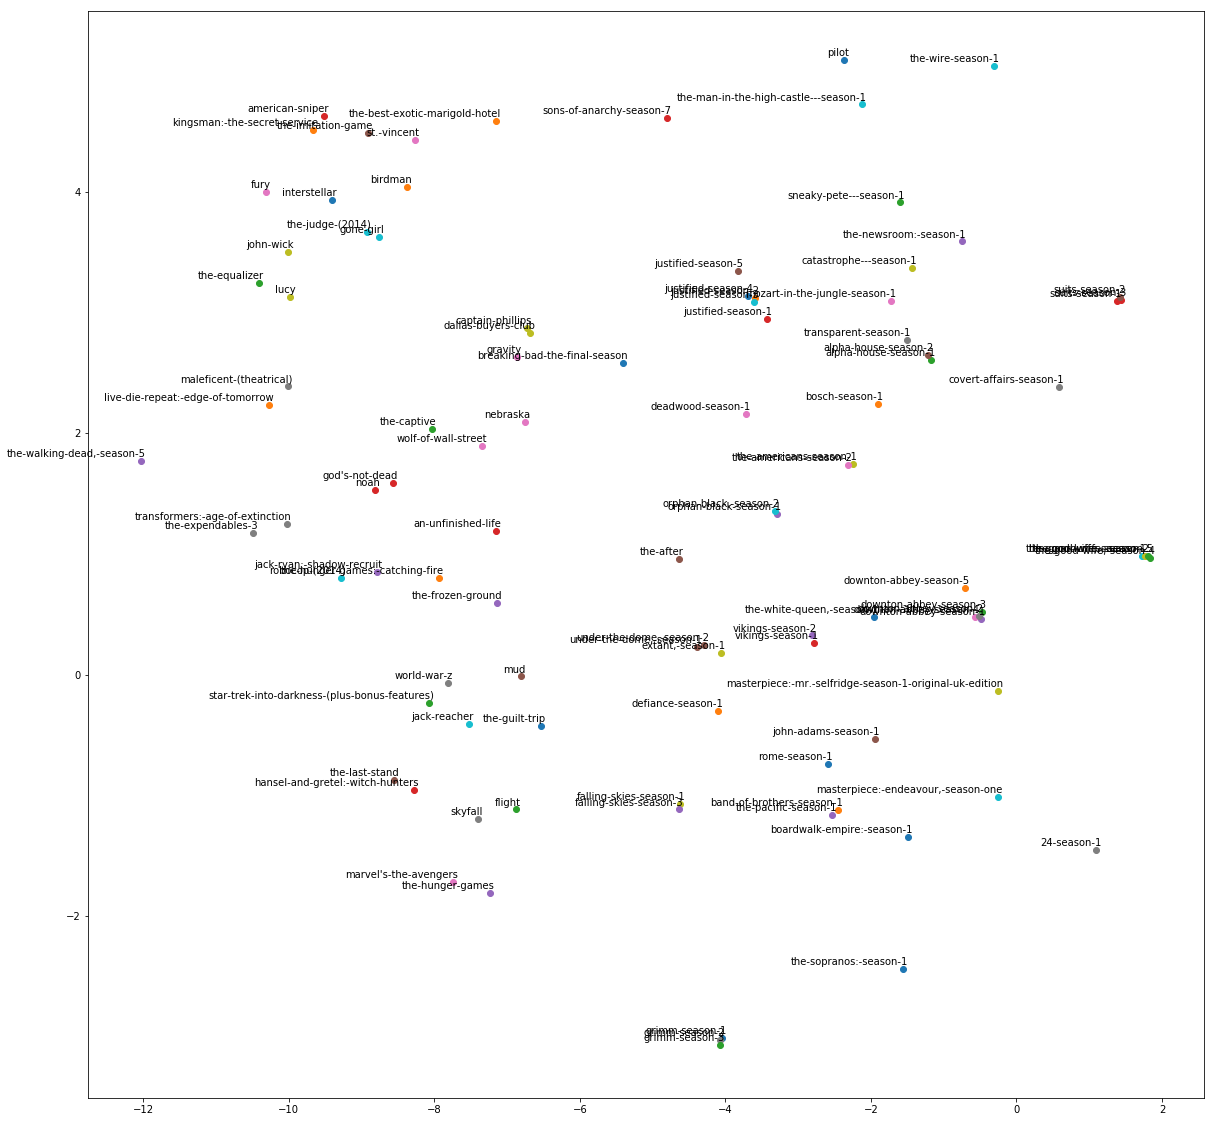

In [55]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(embeddings, product_titles[:100])

---

## Host

Deploy our model to a real-time endpoint.

In [62]:
bt_endpoint = bt.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2018-09-06-05-23-46-507
INFO:sagemaker:Creating endpoint with name blazingtext-2018-09-06-05-01-57-653


--------------------------------------------------------------!

Try generating predictions for a set of titles (some of which are real, some of which are made up).

In [68]:
words = ["sherlock-season-1", 
         "sherlock-season-2",
         "sherlock-season-5",
         'arbitrary-sherlock-holmes-string',
         'the-imitation-game',
         "abcdefghijklmn",
         "keeping-up-with-the-kardashians-season-1"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs_df = pd.DataFrame(json.loads(response))

Calculate correlation and distance.

In [69]:
vecs_df = pd.DataFrame(vecs_df['vector'].values.tolist(), index=vecs_df['word'])

In [70]:
vecs_df = vecs_df.transpose()
vecs_df.corr()

word                                      sherlock-season-1  \
word                                                          
sherlock-season-1                                  1.000000   
sherlock-season-2                                  0.975613   
sherlock-season-5                                  0.937613   
arbitrary-sherlock-holmes-string                   0.651827   
the-imitation-game                                 0.296442   
abcdefghijklmn                                     0.186695   
keeping-up-with-the-kardashians-season-1           0.134656   

word                                      sherlock-season-2  \
word                                                          
sherlock-season-1                                  0.975613   
sherlock-season-2                                  1.000000   
sherlock-season-5                                  0.952221   
arbitrary-sherlock-holmes-string                   0.627469   
the-imitation-game                                 0.274637   
abcdefghijklmn                                     0.185511   
keeping-up-with-the-kardashians-season-1           0.153809   

word                                      sherlock-season-5  \
word                                                          
sherlock-season-1                                  0.937613   
sherlock-season-2                                  0.952221   
sherlock-season-5                                  1.000000   
arbitrary-sherlock-holmes-string                   0.649770   
the-imitation-game                                 0.332390   
abcdefghijklmn                                     0.199241   
keeping-up-with-the-kardashians-season-1           0.180276   

word                                      arbitrary-sherlock-holmes-string  \
word                                                                         
sherlock-season-1                                                 0.651827   
sherlock-season-2                                                 0.627469   
sherlock-season-5                                                 0.649770   
arbitrary-sherlock-holmes-string                                  1.000000   
the-imitation-game                                                0.397691   
abcdefghijklmn                                                    0.144972   
keeping-up-with-the-kardashians-season-1                          0.001460   

word                                      the-imitation-game  abcdefghijklmn  \
word                                                                           
sherlock-season-1                                   0.296442        0.186695   
sherlock-season-2                                   0.274637        0.185511   
sherlock-season-5                                   0.332390        0.199241   
arbitrary-sherlock-holmes-string                    0.397691        0.144972   
the-imitation-game                                  1.000000        0.342502   
abcdefghijklmn                                      0.342502        1.000000   
keeping-up-with-the-kardashians-season-1            0.179073        0.313100   

word                                      keeping-up-with-the-kardashians-season-1  
word                                                                                
sherlock-season-1                                                         0.134656  
sherlock-season-2                                                         0.153809  
sherlock-season-5                                                         0.180276  
arbitrary-sherlock-holmes-string                                          0.001460  
the-imitation-game                                                        0.179073  
abcdefghijklmn                                                            0.313100  
keeping-up-with-the-kardashians-season-1                                  1.000000

In [71]:
for column in vecs_df.columns:
    print(column + ':', np.sum((vecs_df[column] - vecs_df['sherlock-season-1']) ** 2))

sherlock-season-1: 0.0
sherlock-season-2: 0.6693818296600973
sherlock-season-5: 1.6195205850083456
arbitrary-sherlock-holmes-string: 7.67011724427113
the-imitation-game: 14.239632481211343
abcdefghijklmn: 12.930583173774579
keeping-up-with-the-kardashians-season-1: 22.867526431909475


Relative to 'sherlock-season-1':
- 'sherlock-season-5' is made up, but relates well with 'sherlock-season-1' and 'sherlock-season-2'
- 'arbitrary-sherlock-holmes-string' is also made up and relates less well but still fairly strong
- 'the-imitation-game' is another popular Prime video title starring Benedict Cumberbatch and has a moderate relationship, but worse than the arbitrary Sherlock title
- 'abcdefghijklmn' is made up and relates even worse
- 'keeping-up-with-the-kardashians-season-1' somehow manages to relate even worse

Clean-up the endpoint

In [61]:
bt_endpoint.delete_endpoint()

INFO:sagemaker:Deleting endpoint with name: blazingtext-2018-09-06-05-01-57-653


---

---

# Wrap-up

- Built a recommender system on a large dataset quickly and accurately
- Add more features to extend
- Compare to other methods
- Ensemble two models